## Treinamento, Validação e Registro de Modelos de Machine Learning com MLflo

Este notebook tem como objetivo demonstrar o processo completo de treinamento e validação de modelos de machine learning utilizando dados previamente tratados da base de dados da Passos Mágicos. Além de comparar diferentes algoritmos, será realizado o registro dos experimentos no MLflow para garantir rastreabilidade, reprodutibilidade e organização dos resultados. O notebook também servirá como documentação detalhada de cada etapa, permitindo que outros usuários compreendam o fluxo de trabalho e reproduzam os experimentos.

A análise exploratório e a preparação dos dados são detalhados nos outros notebook.

### Abordagem 1

- Utilizar apenas a base de 2022
- Remover as colunas para não ter vazamento de domínio (data leakeage)
- Remover os alunos que entraram em 2022
- Relacionar as colunas com a quantidade de defasagem
- Usar as informações de 2020 e 2021 para prever a classe de pedra 2022

### Abordagem 2

- Considerar a `Abordagem 1`
- Relacionar com os alunos que saíram em 2023
- Relacionar com os alunos que tiveram defasagem negativa

### Abordagem 3

- Unir as bases 2022, 2023 e 2024 e trabalhar como uma única base

### 1. Configuração Inicial

In [85]:
# Importação das bibliotecas
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow


# Configuração do MLflow
mlflow.set_experiment("MLflow Quickstart 2")

mlflow.sklearn.autolog()

2026/02/16 21:34:23 INFO mlflow.tracking.fluent: Experiment with name 'MLflow Quickstart 2' does not exist. Creating a new experiment.


### 2. Carregamento dos dados

In [86]:
# carregamento dos dados de 2022
path_data_refined = "../data/refined"

df_2022 = pd.read_csv(f"{path_data_refined}/pede_refined_2022.csv", sep=";")
with pd.option_context("display.max_columns", None):
    #display(df_2022[df_2022["qtd_defasagem"] > 0].head(5))	
    display(df_2022.head(5))	

,registro_unico,num_ano_nascimento,num_idade,num_ano_ingresso,num_fase_atual,fase_ingresso_estimada,indic_desenv_educ_22,class_geral,class_fase,class_turma,num_avaliacao,indic_auto_avaliacao,indic_engajamento,indic_psicossocial,indic_aprendizagem,nota_media_matematica,nota_media_portugues,nota_media_ingles,nota_media_ponto_virada,nota_media_adequacao,qtd_defasagem,cod_genero,idade_ingresso,is_escola_publica,mudanca_class_pedra_20_21,mudanca_class_pedra_21_22,class_pedra_20_agata,class_pedra_20_ametista,class_pedra_20_ausente,class_pedra_20_quartzo,class_pedra_20_topazio,class_pedra_21_agata,class_pedra_21_ametista,class_pedra_21_ausente,class_pedra_21_quartzo,class_pedra_21_topazio,class_pedra_22_agata,class_pedra_22_ametista,class_pedra_22_quartzo,class_pedra_22_topazio,melhor_avaliacao_score,pior_avaliacao_score,observ_engajamento_tem_destaque,observ_engajamento_tem_melhorar,observ_aprendizagem_tem_destaque,observ_aprendizagem_tem_melhorar,observ_ponto_virada_tem_destaque,observ_ponto_virada_tem_melhorar,flag_observ_psico,defasagem_positiva,defasagem_negativa,flag_bolsa_estudos
0,RA-1,2003,19,2016,7,3,5.783,753,18,10,4,8.3,4.1,5.6,4.0,2.7,3.5,6.0,7.278,5.0,-1,1,13,1,0,-2,0,1,0,0,0,0,1,0,0,0,0,0,1,0,5,2,0,1,0,1,0,1,1,0,1,1
1,RA-2,2005,17,2017,7,3,7.055,469,8,3,4,8.8,5.2,6.3,6.8,6.3,4.5,9.7,6.778,10.0,0,1,12,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,5,4,0,1,0,1,0,1,0,0,0,0
2,RA-3,2005,17,2016,7,2,6.591,629,13,6,4,0.0,7.9,5.6,5.6,5.8,4.0,6.9,7.556,10.0,0,1,11,0,0,-1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,5,4,1,0,0,1,1,0,0,0,0,0
3,RA-4,2005,17,2017,7,3,5.951,731,15,7,4,8.8,4.5,5.6,5.0,2.8,3.5,8.7,5.278,10.0,0,0,12,0,0,-2,0,1,0,0,0,0,1,0,0,0,0,0,1,0,4,2,0,1,0,1,0,1,1,0,0,0
4,RA-5,2005,17,2016,7,2,7.427,344,6,2,4,7.9,8.6,5.6,5.2,7.0,2.9,5.7,7.389,10.0,0,1,11,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,5,4,1,0,0,1,0,1,1,0,0,0


In [87]:
# Selecionar os dados para treinamento 
# "num_ano_nascimento", "num_ano_ingresso", "cod_genero", "fase_ingresso_estimada", "num_fase_atual", 
# "class_pedra_20_agata", "class_pedra_20_ametista", "class_pedra_20_ausente", "class_pedra_20_quartzo",
# "class_pedra_20_topazio", "class_pedra_21_agata", "class_pedra_21_ametista", "class_pedra_21_ausente",
# "class_pedra_21_quartzo", "class_pedra_21_topazio",

cols = [ "num_idade", "is_escola_publica",
"qtd_defasagem", "idade_ingresso", "mudanca_class_pedra_20_21",
 "defasagem_negativa", "flag_bolsa_estudos"]


df_2022_ap01 = df_2022[df_2022["num_ano_ingresso"] < 2022][cols].copy()
with pd.option_context("display.max_columns", None):
    display(df_2022_ap01.head(5))

,num_idade,is_escola_publica,qtd_defasagem,idade_ingresso,mudanca_class_pedra_20_21,defasagem_negativa,flag_bolsa_estudos
0,19,1,-1,13,0,1,1
1,17,0,0,12,0,0,0
2,17,0,0,11,0,0,0
3,17,0,0,12,0,0,0
4,17,0,0,11,0,0,0


2026/02/16 21:35:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\arquivos_antigos\Projetos\FIAP\Fase5\tech_challenger_5_project\.venv\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."
2026/02/16 21:35:20 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


Tabela de comparação:
defasagem_negativa   0    1
cluster                    
0                   57   46
1                   54  191
2                   15   98

Adjusted Rand Index (ARI): 0.07597893621351186
Normalized Mutual Information (NMI): 0.07073572442252704


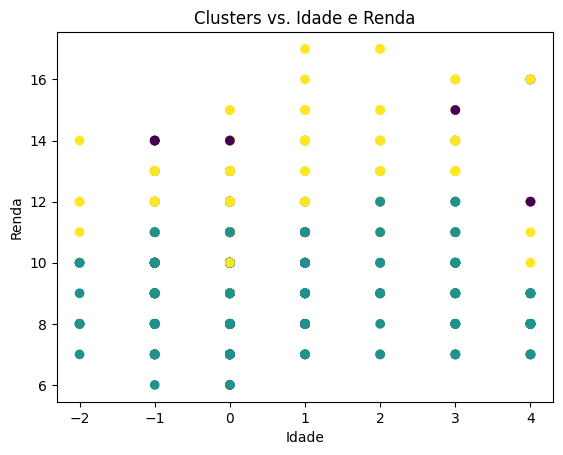

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

with mlflow.start_run(run_name="KMeans_Teste_01"):
    # 1. Separar features (sem incluir qtd_defasagem)
    X = df_2022_ap01.drop(columns=['qtd_defasagem', 'defasagem_negativa'])

    # 2. Padronizar os dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. Treinar K-Means
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df_2022_ap01['cluster'] = kmeans.fit_predict(X_scaled)

    # 4. Comparar clusters com a classe resposta
    print("Tabela de comparação:")
    print(pd.crosstab(df_2022_ap01['cluster'], df_2022_ap01['defasagem_negativa']))

    # 5. Métricas externas de validação
    ari = adjusted_rand_score(df_2022_ap01['defasagem_negativa'], df_2022_ap01['cluster'])
    nmi = normalized_mutual_info_score(df_2022_ap01['defasagem_negativa'], df_2022_ap01['cluster'])

    mlflow.log_metric("ARI", ari)
    mlflow.log_metric("NMI", nmi)

print("\nAdjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

# 6. Visualização
plt.scatter(df_2022_ap01['mudanca_class_pedra_20_21'], df_2022_ap01['idade_ingresso'], c=df_2022_ap01['cluster'], cmap='viridis')
plt.xlabel('Idade')
plt.ylabel('Renda')
plt.title('Clusters vs. Idade e Renda')
plt.show()

In [91]:
mlflow.end_run()

In [76]:
mlflow.log_metric("NMI", nmi)

### 3. Divisão em treino/validação/teste

### 4. Treinamento de modelos

### 5. Validação e comparação de desempenho

### 6. Registro no MLflow